In [ ]:
import csv

In [ ]:
# Create the CSV file with headers
with open("search_data.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal", "Path_Cost", "Ant_Type", "Alpha", "Beta"])


In [ ]:
def log_data(slope, elevation_change, pheromone_level, distance_to_goal, path_cost, ant_type, alpha, beta):
    with open("search_data.csv", "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([slope, elevation_change, pheromone_level, distance_to_goal, path_cost, ant_type, alpha, beta])

In [ ]:
# Create the CSV file with headers for Predictive Pheromone Updates
with open("path_success_data.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Path_Success_Prob", "Distance_To_Goal", "Elevation_Change", "Pheromone_Level", "Path_Cost"])

In [ ]:
# Create the CSV file with headers for Meta-Ant Strategy Switching
with open("meta_ant_strategy_data.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal", "Ant_Type"])

In [ ]:
# Create the CSV file with headers for Ant Path Clustering
with open("path_clustering_data.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Total_Pheromone", "Path_Cost", "Distance_To_Goal"])

In [ ]:
import numpy as np
from scipy.ndimage import zoom
import random

# ==== CONFIG ====
GRID_SIZE = (30, 30)
NUM_ANTS = 50
NUM_ITERATIONS = 20
EVAPORATION_RATE = 0.1
ALPHA = 1.0
BETA = 2.0
Q = 100

START = (0, 0)
END = (29, 29)

# ==== 1. TERRAIN ====

base_noise = np.random.rand(10, 10)
terrain = zoom(base_noise, (GRID_SIZE[0]/10, GRID_SIZE[1]/10))
terrain = (terrain * 255).astype(int)
pheromone_map = np.ones(GRID_SIZE)

# ==== 2. DISTANCE FUNCTION WITH ELEVATION ====
def distance_with_elevation(a, b, terrain):
    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])
    dh = abs(terrain[a] - terrain[b])
    return np.sqrt(dx*dx + dy*dy + dh*dh)

# ==== 3. CHAOS FUNCTION ====
def chaos_map(x):
    return 4 * x * (1 - x)

# ==== 4. ANT WALK ====
def ant_walk_with_chaos(start, end, terrain, pheromone_map, chaos_seed):
    path = [start]
    visited = set()
    pos = start
    chaos = chaos_seed
    steps = 0
    max_steps = GRID_SIZE[0] * GRID_SIZE[1] * 2

    while pos != end and steps < max_steps:
        steps += 1
        visited.add(pos)

        # Define possible directions
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
        neighbors = [(pos[0] + dx, pos[1] + dy) for dx, dy in directions
                     if 0 <= pos[0] + dx < GRID_SIZE[0] and 0 <= pos[1] + dy < GRID_SIZE[1]
                     and (pos[0] + dx, pos[1] + dy) not in visited]

        if not neighbors:
            return None

        # Calculate probabilities for neighbors
        move_probs = []
        total = 0
        for n in neighbors:
            pheromone = pheromone_map[n]
            distance = distance_with_elevation(pos, n, terrain)
            heuristic = 1 / (distance + 1e-3)
            prob = (pheromone * ALPHA) * (heuristic * BETA)
            move_probs.append(prob)
            total += prob

        if total == 0:
            return None

        # Normalize probabilities
        move_probs = [p / total for p in move_probs]

        # Select the next position
        chaos = chaos_map(chaos)
        choice_index = np.random.choice(len(neighbors), p=move_probs)
        next_pos = neighbors[choice_index]
        path.append(next_pos)

        # Calculate features
        slope = abs(terrain[pos] - terrain[next_pos]) / distance_with_elevation(pos, next_pos, terrain)
        elevation_change = abs(terrain[pos] - terrain[next_pos])
        pheromone_level = pheromone_map[next_pos]
        distance_to_goal = distance_with_elevation(next_pos, end, terrain)

        # Example: Assign ant type (can refine logic)
        if slope > 0.5:
            ant_type = "Energy-Sensitive"
        elif distance_to_goal < 10:
            ant_type = "Distance-Sensitive"
        else:
            ant_type = "Mixed"

        # Log the data
        path_cost = sum(distance_with_elevation(path[i], path[i+1], terrain) for i in range(len(path)-1)) if len(path) > 1 else 0
        log_data(slope, elevation_change, pheromone_level, distance_to_goal,path_cost, ant_type, ALPHA, BETA)

        with open("meta_ant_strategy_data.csv", "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([slope, elevation_change, pheromone_level, distance_to_goal, ant_type])

        # Update the position
        pos = next_pos

    return path if pos == end else None
# ==== 5. ACO MAIN ====
def multi_race_ant_colony(start, end, terrain, iterations=NUM_ITERATIONS):
    best_path = None
    best_cost = float('inf')

    for iter in range(iterations):
        all_paths = []
        chaos_values = [random.random() for _ in range(NUM_ANTS)]
        for c in chaos_values:
            path = ant_walk_with_chaos(start, end, terrain, pheromone_map, c)
            if path:
                all_paths.append(path)
                cost = sum(distance_with_elevation(path[i], path[i+1], terrain) for i in range(len(path)-1))
                if cost < best_cost:
                    best_path = path
                    best_cost = cost

        # Log path success data
        with open("path_success_data.csv", "a", newline="") as file:
            writer = csv.writer(file)
            for path in all_paths:
                total_pheromone = sum(pheromone_map[pos] for pos in path)
                total_distance = sum(distance_with_elevation(path[i], path[i+1], terrain) for i in range(len(path)-1))
                elevation_change = abs(terrain[path[0]] - terrain[path[-1]])  # Change from start to end
                path_cost = total_distance  # Example metric
                path_success_prob = total_pheromone / (total_distance + 1e-3)  # Example calculation

                # Write to the CSV
                writer.writerow([path_success_prob, total_distance, elevation_change, total_pheromone, path_cost])
        # Log clustering data
        with open("path_clustering_data.csv", "a", newline="") as file:
            writer = csv.writer(file)
            for path in all_paths:
                total_pheromone = sum(pheromone_map[pos] for pos in path)
                path_cost = sum(distance_with_elevation(path[i], path[i+1], terrain) for i in range(len(path)-1))
                distance_to_goal = distance_with_elevation(path[-1], end, terrain)

                # Write to the CSV
                writer.writerow([total_pheromone, path_cost, distance_to_goal])


        # Update pheromone map
        pheromone_map[:] *= (1 - EVAPORATION_RATE)
        for path in all_paths:
            cost = sum(distance_with_elevation(path[i], path[i+1], terrain) for i in range(len(path)-1))
            for cell in path:
                pheromone_map[cell] += Q / cost

    return best_path

# ==== RUN EVERYTHING ====
best_path = multi_race_ant_colony(START, END, terrain)

if best_path:
  print("best path is found")

else:
    print("No path found.")

best path is found


In [ ]:
import pandas as pd

# Load the logged data
search_data = pd.read_csv("search_data.csv")

# Check the first few rows
print(search_data.head())

# Verify column structure
print(search_data.info())
print(search_data.columns)

      Slope  Elevation_Change  Pheromone_Level  Distance_To_Goal  Path_Cost  \
0  0.998404                25              1.0         47.370877  25.039968   
1  0.998868                21              1.0         61.008196  46.063764   
2  0.973329                 6              1.0         65.772335  52.228178   
3  0.998618                19              1.0         81.547532  71.254476   
4  0.816497                 2              1.0         79.749608  73.703965   

           Ant_Type  Alpha  Beta  
0  Energy-Sensitive    1.0   2.0  
1  Energy-Sensitive    1.0   2.0  
2  Energy-Sensitive    1.0   2.0  
3  Energy-Sensitive    1.0   2.0  
4  Energy-Sensitive    1.0   2.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220523 entries, 0 to 220522
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Slope             220523 non-null  float64
 1   Elevation_Change  220523 non-null  int64  
 2   Pheromon

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import pickle

# Define features (X) and labels (y)
X = search_data[["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal"]]
y = search_data[["Alpha", "Beta"]]
if X.empty or y.empty:
       print("Error: The search_data is empty. Cannot train a model with no data.")
else:
    # Split the data: 80% training, 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Regressor
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error on Test Data:", mse)

    # Save the trained model
    with open("adaptive_heuristic_model.pkl", "wb") as file:
         pickle.dump(model, file)

Mean Squared Error on Test Data: 0.0


In [ ]:
import pandas as pd

# Load the logged data
data = pd.read_csv("path_success_data.csv")

# Check the first few rows
print(data.head())

# Verify column structure
print(data.info())

   Path_Success_Prob  Distance_To_Goal  Elevation_Change  Pheromone_Level  \
0           0.065233       2299.461587                 1       150.000000   
1           0.047352       3005.714936                 1       142.326749   
2           0.035550       4619.595142                 1       164.227479   
3           0.039970       1621.480893                 1        64.810034   
4           0.028172       2320.126503                 1        65.363577   

     Path_Cost  
0  2299.461587  
1  3005.714936  
2  4619.595142  
3  1621.480893  
4  2320.126503  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Path_Success_Prob  41 non-null     float64
 1   Distance_To_Goal   41 non-null     float64
 2   Elevation_Change   41 non-null     int64  
 3   Pheromone_Level    41 non-null     float64
 4   Path_Cost          41 non-null     float

In [ ]:
# Load the logged data
data = pd.read_csv("path_success_data.csv")

# Define features (X) and label (y)
X = data[["Distance_To_Goal", "Elevation_Change", "Pheromone_Level", "Path_Cost"]]
y = data["Path_Success_Prob"]

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree Regressor
success_model = DecisionTreeRegressor(random_state=42)
success_model.fit(X_train, y_train)

# Evaluate the model
y_pred = success_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error for Predictive Pheromone Model:", mse)

# Save the trained model
with open("predictive_pheromone_model.pkl", "wb") as file:
    pickle.dump(success_model, file)

Mean Squared Error for Predictive Pheromone Model: 0.00014675118551234572


In [ ]:
import pandas as pd

# Load the logged data
data = pd.read_csv("meta_ant_strategy_data.csv")

# Check the first few rows
print(data.head())

# Verify column structure
print(data.info())

      Slope  Elevation_Change  Pheromone_Level  Distance_To_Goal  \
0  0.998404                25              1.0         47.370877   
1  0.998868                21              1.0         61.008196   
2  0.973329                 6              1.0         65.772335   
3  0.998618                19              1.0         81.547532   
4  0.816497                 2              1.0         79.749608   

           Ant_Type  
0  Energy-Sensitive  
1  Energy-Sensitive  
2  Energy-Sensitive  
3  Energy-Sensitive  
4  Energy-Sensitive  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220523 entries, 0 to 220522
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Slope             220523 non-null  float64
 1   Elevation_Change  220523 non-null  int64  
 2   Pheromone_Level   220523 non-null  float64
 3   Distance_To_Goal  220523 non-null  float64
 4   Ant_Type          220523 non-null  object 
dtypes: float

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pickle

# Load the logged data
data = pd.read_csv("meta_ant_strategy_data.csv")

# Encode the categorical 'Ant_Type' column
encoder = LabelEncoder()
data["Ant_Type"] = encoder.fit_transform(data["Ant_Type"])

# Define features (X) and label (y)
X = data[["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal"]]
y = data["Ant_Type"]

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
strategy_model = RandomForestClassifier(random_state=42)
strategy_model.fit(X_train, y_train)

# Evaluate the model
y_pred = strategy_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for Meta-Ant Strategy Model:", accuracy)

# Save the trained model
with open("meta_ant_strategy_model.pkl", "wb") as file:
    pickle.dump(strategy_model, file)

Accuracy for Meta-Ant Strategy Model: 1.0


In [ ]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load your dataset
df = pd.read_csv("search_data.csv")

# Define feature and target columns
feature_columns = ["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal"]
target_column = "Ant_Type"

# Extract data
X = df[feature_columns]
y = df[target_column]

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train model
model = RandomForestClassifier()
model.fit(X, y_encoded)

# Save model and encoder
with open("meta_ant_strategy_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("strategy_label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)


In [ ]:
import pandas as pd

# Load the logged data
data = pd.read_csv("path_clustering_data.csv")

# Check the first few rows
print(data.head())

# Verify column structure
print(data.info())

   Total_Pheromone    Path_Cost  Distance_To_Goal
0       150.000000  2299.461587               0.0
1       142.326749  3005.714936               0.0
2       164.227479  4619.595142               0.0
3        64.810034  1621.480893               0.0
4        65.363577  2320.126503               0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Total_Pheromone   41 non-null     float64
 1   Path_Cost         41 non-null     float64
 2   Distance_To_Goal  41 non-null     float64
dtypes: float64(3)
memory usage: 1.1 KB
None


Cluster Assignments: [2 0 1 2 2 2 2 2 2 2 2 2 2 2 0 2 1 0 2 0 1 2 0 0 1 1 2 0 2 0 2 0 0 0 0 2 2
 2 2 2 0]


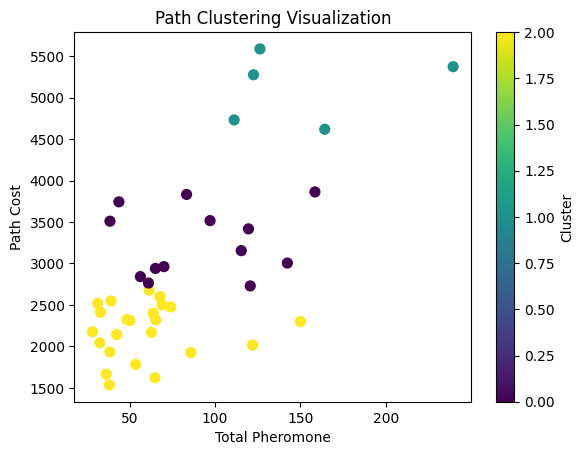

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the logged data
data = pd.read_csv("path_clustering_data.csv")

# Define features for clustering
X = data[["Total_Pheromone", "Path_Cost", "Distance_To_Goal"]]

# Train the K-Means clustering model
num_clusters = 3  # Example: Define the number of clusters
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = clustering_model.fit_predict(X)

# Add cluster labels to the dataset
data["Cluster_Label"] = cluster_labels
print("Cluster Assignments:", cluster_labels)

# Save the trained model
with open("ant_path_clustering_model.pkl", "wb") as file:
    pickle.dump(clustering_model, file)

# Visualize the clusters
plt.scatter(X["Total_Pheromone"], X["Path_Cost"], c=cluster_labels, cmap='viridis', s=50)
plt.xlabel("Total Pheromone")
plt.ylabel("Path Cost")
plt.title("Path Clustering Visualization")
plt.colorbar(label="Cluster")
plt.show()

Iteration 1/20
New best path found! Cost: 1132.25
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
No paths found in this iteration
Iteration 8/20
No paths found in this iteration
Iteration 9/20
No paths found in this iteration
Iteration 10/20
Iteration 11/20
Iteration 12/20
No paths found in this iteration
Iteration 13/20
No paths found in this iteration
Iteration 14/20
No paths found in this iteration
Iteration 15/20
Iteration 16/20
No paths found in this iteration
Iteration 17/20
No paths found in this iteration
Iteration 18/20
Iteration 19/20
Iteration 20/20


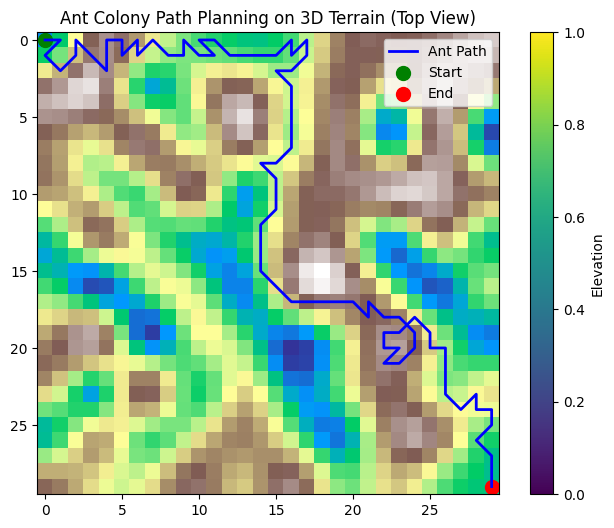

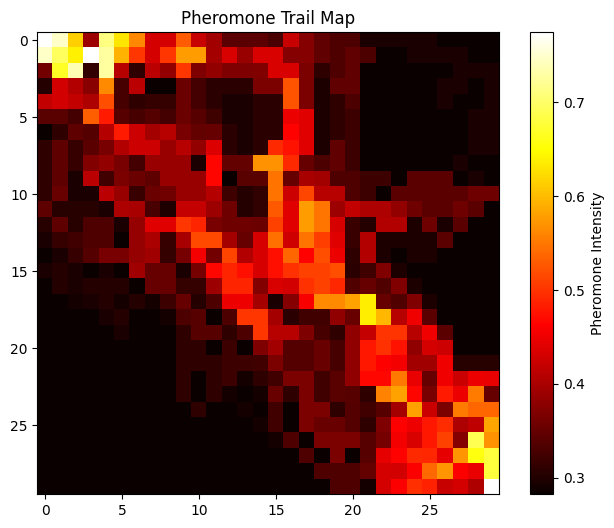

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import csv
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import pickle

# ==== CONFIG ====
GRID_SIZE = (30, 30)
NUM_ANTS = 50
NUM_ITERATIONS = 20
EVAPORATION_RATE = 0.1
Q = 100

START = (0, 0)
END = (29, 29)

# ==== TERRAIN ====
base_noise = np.random.rand(10, 10)
terrain = zoom(base_noise, (GRID_SIZE[0]/10, GRID_SIZE[1]/10))
terrain = (terrain * 255).astype(int)
pheromone_map = np.ones(GRID_SIZE)
# ==== DISTANCE FUNCTION WITH ELEVATION ====
def distance_with_elevation(a, b, terrain):
    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])
    dh = abs(terrain[a] - terrain[b])
    return np.sqrt(dx*dx + dy*dy + dh*dh)

# ==== CHAOS FUNCTION ====
def chaos_map(x):
    return 4 * x * (1 - x)

# ==== ANT WALK ====

# ==== ANT WALK ====
def predict_strategy(features, strategy_model, encoder):
    """
    Predict ant strategy with proper feature naming
    """
    try:
        # Convert to DataFrame with correct column names
        if isinstance(features, np.ndarray):
            # If features is just a numpy array, convert to DataFrame with correct names
            df = pd.DataFrame(
                features,
                columns=["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal"]
            )
        else:
            # If already a DataFrame, ensure column names are correct
            df = pd.DataFrame(
                features,
                columns=["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal"]
            )

        # Now predict with properly named features
        predicted_strategy = strategy_model.predict(df)[0]
        ant_type = encoder.inverse_transform([predicted_strategy])[0]
        return ant_type
    except Exception as e:
        print(f"Strategy prediction error: {str(e)}")
        return "Mixed"  # Default strategy type

# ==== ANT WALK ====
def ant_walk_with_chaos(start, end, terrain, pheromone_map, chaos_seed, heuristic_model, strategy_model, encoder):
    path = [start]
    visited = set([start])  # Use set for O(1) lookups
    pos = start
    chaos = chaos_seed
    steps = 0
    max_steps = GRID_SIZE[0] * GRID_SIZE[1] * 2

    while pos != end and steps < max_steps:
        steps += 1

        # Define possible directions
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
        neighbors = []

        # Find valid neighbors
        for dx, dy in directions:
            nx, ny = pos[0] + dx, pos[1] + dy
            if (0 <= nx < GRID_SIZE[0] and
                0 <= ny < GRID_SIZE[1] and
                (nx, ny) not in visited):
                neighbors.append((nx, ny))

        if not neighbors:
            return None  # Dead end

        # Calculate features for first neighbor as a sample
        if neighbors:
            sample_neighbor = neighbors[0]

            # Calculate features safely
            try:
                # Safe distance calculation
                slope = abs(float(terrain[pos]) - float(terrain[sample_neighbor])) / max(distance_with_elevation(pos, sample_neighbor, terrain), 0.1)
                elevation_change = abs(float(terrain[pos]) - float(terrain[sample_neighbor]))
                pheromone_level = float(pheromone_map[sample_neighbor])
                distance_to_goal = float(distance_with_elevation(sample_neighbor, end, terrain))

                # Create features DataFrame with column names
                features = pd.DataFrame(
                    [[slope, elevation_change, pheromone_level, distance_to_goal]],
                    columns=["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal"]
                )

                # Predict alpha and beta values
                try:
                    alpha_beta = heuristic_model.predict(features)
                    alpha, beta = alpha_beta[0]
                except Exception as e:
                    print(f"Heuristic prediction error: {str(e)}")
                    # Fallback if prediction fails
                    alpha, beta = 1.0, 2.0
            except Exception as e:
                print(f"Feature calculation error: {str(e)}")
                # Default values if calculation fails
                alpha, beta = 1.0, 2.0

        else:
            # Default values if no neighbors
            alpha, beta = 1.0, 2.0

        # Calculate probabilities for neighbors
        move_probs = []
        total = 0

        for n in neighbors:
            try:
                pheromone = float(pheromone_map[n])
                distance = float(distance_with_elevation(pos, n, terrain))
                heuristic = 1.0 / (distance + 1e-3)  # Avoid division by zero
                prob = float((pheromone ** alpha) * (heuristic ** beta))
                move_probs.append(prob)
                total += prob
            except Exception as e:
                # Add small probability if calculation fails
                move_probs.append(0.1)
                total += 0.1

        if total <= 0:
            # If all probabilities are zero or negative, use uniform distribution
            move_probs = [1.0/len(neighbors) for _ in neighbors]
        else:
            # Normalize probabilities
            move_probs = [float(p / total) for p in move_probs]

        # Make sure probabilities sum to 1
        if sum(move_probs) <= 0 or any(np.isnan(p) for p in move_probs):
            move_probs = [1.0/len(neighbors) for _ in neighbors]

        # Select next position
        try:
            chaos = chaos_map(chaos)  # Update chaos value
            choice_index = np.random.choice(len(neighbors), p=move_probs)
            next_pos = neighbors[choice_index]
        except Exception as e:
            # Random choice if weighted selection fails
            next_pos = random.choice(neighbors)

        # Add to path and visited set
        path.append(next_pos)
        visited.add(next_pos)

        # Try to predict ant strategy using the new helper function
        try:
            # Create features DataFrame with proper column names
            strategy_features = pd.DataFrame(
                [[slope, elevation_change, pheromone_level, distance_to_goal]],
                columns=["Slope", "Elevation_Change", "Pheromone_Level", "Distance_To_Goal"]
            )

            # Use the helper function instead of direct prediction
            ant_type = predict_strategy(strategy_features, strategy_model, encoder)
            # No need to use the predicted strategy now, just for logging
        except Exception as e:
            print(f"Strategy prediction error: {str(e)}")
            # Continue if strategy prediction fails
            pass

        # Update position
        pos = next_pos

    # Return path if destination reached, otherwise None
    return path if pos == end else None
# ==== ACO MAIN ====
def multi_race_ant_colony(start, end, terrain, pheromone_map,
                          heuristic_model, strategy_model, encoder,
                          ranking_model, clustering_model,
                          iterations=NUM_ITERATIONS, num_ants=NUM_ANTS):

    best_path = None
    best_cost = float('inf')

    for iter in range(iterations):
        print(f"Iteration {iter+1}/{iterations}")
        all_paths = []
        # Generate chaos values for each ant
        chaos_values = [random.random() for _ in range(num_ants)]

        # Make each ant find a path
        for ant_idx, c in enumerate(chaos_values):
            try:
                path = ant_walk_with_chaos(start, end, terrain, pheromone_map, c,
                                          heuristic_model, strategy_model, encoder)
                if path:
                    # Calculate path cost
                    cost = sum(distance_with_elevation(path[i], path[i+1], terrain)
                              for i in range(len(path)-1))
                    all_paths.append((path, cost))

                    # Update best path if better
                    if cost < best_cost:
                        best_path = path
                        best_cost = cost
                        print(f"New best path found! Cost: {best_cost:.2f}")
            except Exception as e:
                print(f"Error with ant {ant_idx}: {str(e)}")
                continue

        if not all_paths:
            print("No paths found in this iteration")
            continue  # Skip to next iteration if no paths found

        # Try to rank paths using the model
        ranked_paths = []
        for path, cost in all_paths:
            try:
                # Calculate features for ranking
                total_pheromone = sum(pheromone_map[pos] for pos in path)
                elevation_change = abs(terrain[path[0]] - terrain[path[-1]])

                # Create features for prediction with column names
                path_features = pd.DataFrame(
                    [[cost, elevation_change, total_pheromone, cost]],
                    columns=["Distance_To_Goal", "Elevation_Change", "Pheromone_Level", "Path_Cost"]
                )

                # Predict success probability
                predicted_success = ranking_model.predict(path_features)[0]
                ranked_paths.append((path, predicted_success, cost))
            except Exception as e:
                print(f"Ranking error: {str(e)}")
                # If prediction fails, use cost as ranking
                ranked_paths.append((path, 1.0/cost, cost))

        # Sort by predicted success (higher is better)
        ranked_paths.sort(key=lambda x: x[1], reverse=True)

        # Update pheromone based on ranked paths
        pheromone_map *= (1 - EVAPORATION_RATE)

        # Top paths get more pheromone
        for i, (path, _, cost) in enumerate(ranked_paths):
            # More weight to better paths
            weight = 1.0 / (i + 1)

            for cell in path:
                pheromone_map[cell] += (Q * weight) / (cost + 1e-6)  # Avoid division by zero

    return best_path

# Load models only once
with open("adaptive_heuristic_model.pkl", "rb") as file:
    heuristic_model = pickle.load(file)
with open("meta_ant_strategy_model.pkl", "rb") as file:
    strategy_model = pickle.load(file)
with open("strategy_label_encoder.pkl", "rb") as file:
    encoder = pickle.load(file)
with open("predictive_pheromone_model.pkl", "rb") as file:
    ranking_model = pickle.load(file)
with open("ant_path_clustering_model.pkl", "rb") as file:
    clustering_model = pickle.load(file)

# Run algorithm
# ==== VISUALIZATION ====
def plot_path_on_terrain(terrain, path, start, end):
    plt.figure(figsize=(8, 6))
    plt.imshow(terrain, cmap='terrain')
    if path:
        x, y = zip(*path)
        plt.plot(y, x, color='blue', linewidth=2, label='Ant Path')
    plt.scatter(start[1], start[0], color='green', s=100, label='Start')
    plt.scatter(end[1], end[0], color='red', s=100, label='End')
    plt.colorbar(label='Elevation')
    plt.title("Ant Colony Path Planning on 3D Terrain (Top View)")**xx
    plt.legend()
    plt.grid(False)
    plt.show()

def plot_pheromone_map(pheromone_map):
    plt.figure(figsize=(8, 6))
    plt.imshow(pheromone_map, cmap='hot')
    plt.colorbar(label='Pheromone Intensity')
    plt.title("Pheromone Trail Map")
    plt.grid(False)
    plt.show()

def plot_3d_terrain_with_path(terrain, path=None, start=None, end=None):
    # Code for visualization (as in your original example)...
    pass

# ==== RUN EVERYTHING ====
best_path = multi_race_ant_colony(
    START, END, terrain, pheromone_map,
    heuristic_model, strategy_model, encoder,
    ranking_model, clustering_model
)

if best_path:
    plot_path_on_terrain(terrain, best_path, START, END)
    plot_pheromone_map(pheromone_map)
else:
    print("No path found.")
